In [1]:
# 1 — Imports & display settings (code cell)
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# plotting defaults
sns.set(style="whitegrid")
plt.rcParams['figure.dpi'] = 120
plt.rcParams['savefig.dpi'] = 150

# folder to save outputs
OUT_DIR = r"C:\Users\007bo\OneDrive\Desktop\IIT\capstone\2\python_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# quick display
pd.options.display.max_rows = 50
pd.options.display.max_columns = 200


In [2]:
#Load data - Load from CSV
csv_path = r"C:\Users\007bo\OneDrive\Desktop\IIT\capstone\2\health_care.csv"
df = pd.read_csv(csv_path, low_memory=False)
df.shape


(101766, 47)

In [3]:
#Quick inspection (code cell)
# first look
df.head()
df.info()
# missing summary
missing = df.isna().sum().sort_values(ascending=False)
missing[missing>0].head(30)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 47 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   admission_type_id         101766 non-null  int64 
 6   discharge_disposition_id  101766 non-null  int64 
 7   admission_source_id       101766 non-null  int64 
 8   time_in_hospital          101766 non-null  int64 
 9   num_lab_procedures        101766 non-null  int64 
 10  num_procedures            101766 non-null  int64 
 11  num_medications           101766 non-null  int64 
 12  number_outpatient         101766 non-null  int64 
 13  number_emergency          101766 non-null  int64 
 14  numb

max_glu_serum    96420
a1cresult        84748
dtype: int64

In [4]:
#Cell A — quick consistency check
# show top problematic columns and a quick value check
cols_check = ['readmitted','readmit_30d'] if 'readmit_30d' in df.columns else ['readmitted']
print("Unique values for 'readmitted':")
print(df['readmitted'].value_counts(dropna=False).head(20))
print("\nSample diag_1 top values:")
print(df['diag_1'].value_counts().head(10))
print("\nMedication column sample values (first 8 meds):")
meds = ['metformin','repaglinide','nateglinide','chlorpropamide','glimepiride','acetohexamide','glipizide','glyburide']
for m in meds:
    if m in df.columns:
        print(m, ":", df[m].value_counts(dropna=False).head(10).to_dict())

Unique values for 'readmitted':
readmitted
NO     54864
>30    35545
<30    11357
Name: count, dtype: int64

Sample diag_1 top values:
diag_1
428    6862
414    6581
786    4016
410    3614
486    3508
427    2766
491    2275
715    2151
682    2042
434    2028
Name: count, dtype: int64

Medication column sample values (first 8 meds):
metformin : {'No': 81778, 'Steady': 18346, 'Up': 1067, 'Down': 575}
repaglinide : {'No': 100227, 'Steady': 1384, 'Up': 110, 'Down': 45}
nateglinide : {'No': 101063, 'Steady': 668, 'Up': 24, 'Down': 11}
chlorpropamide : {'No': 101680, 'Steady': 79, 'Up': 6, 'Down': 1}
glimepiride : {'No': 96575, 'Steady': 4670, 'Up': 327, 'Down': 194}
acetohexamide : {'No': 101765, 'Steady': 1}
glipizide : {'No': 89080, 'Steady': 11356, 'Up': 770, 'Down': 560}
glyburide : {'No': 91116, 'Steady': 9274, 'Up': 812, 'Down': 564}


In [5]:
#Cell-B --Let’s now create the proper 30-day readmission flag (readmit_30d) and clean placeholder values.

#  normalize and create readmit flag
df.columns = [c.strip() for c in df.columns]
df = df.replace(['?', 'None', 'NA', 'null', 'NULL', 'unknown', 'Unknown'], np.nan)

# Create 30-day readmission flag (<30 = Yes; otherwise No)
df['readmitted_raw'] = df['readmitted'].astype(str).str.strip()
df['readmit_30d'] = np.where(df['readmitted_raw'].str.strip() == '<30', 'Yes', 'No')

# Quick check
print(df['readmit_30d'].value_counts())

readmit_30d
No     90409
Yes    11357
Name: count, dtype: int64


In [6]:
# — Cell-C----Convert medication columns to binary (0/1)

# List of medication columns we found earlier
med_cols = [
    'metformin','repaglinide','nateglinide','chlorpropamide','glimepiride',
    'acetohexamide','glipizide','glyburide','tolbutamide','pioglitazone',
    'rosiglitazone','acarbose','miglitol','troglitazone','tolazamide',
    'examide','citoglipton','insulin','glyburide-metformin','glipizide-metformin',
    'glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone'
]

# Keep only those that actually exist in your dataframe
med_cols = [c for c in med_cols if c in df.columns]

# Convert to binary: 1 if Steady/Up/Down (active med), 0 if No
for c in med_cols:
    df[c + '_bin'] = np.where(df[c].astype(str).str.upper().isin(['STEADY','UP','DOWN']), 1,
                              np.where(df[c].astype(str).str.upper().isin(['NO']), 0, np.nan))

# Quick summary: show first few binary conversions
df[[c + '_bin' for c in med_cols]].head()


,metformin_bin,repaglinide_bin,nateglinide_bin,chlorpropamide_bin,glimepiride_bin,acetohexamide_bin,glipizide_bin,glyburide_bin,tolbutamide_bin,pioglitazone_bin,rosiglitazone_bin,acarbose_bin,miglitol_bin,troglitazone_bin,tolazamide_bin,examide_bin,citoglipton_bin,insulin_bin,glyburide-metformin_bin,glipizide-metformin_bin,glimepiride-pioglitazone_bin,metformin-rosiglitazone_bin,metformin-pioglitazone_bin
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [7]:
#Quick sanity check (next small step)
# Count how many patients were actively on each medication
active_meds = df[[c + '_bin' for c in med_cols]].sum().sort_values(ascending=False)
print(active_meds.head(15))


insulin_bin                54383.0
metformin_bin              19988.0
glipizide_bin              12686.0
glyburide_bin              10650.0
pioglitazone_bin            7328.0
rosiglitazone_bin           6365.0
glimepiride_bin             5191.0
repaglinide_bin             1539.0
glyburide-metformin_bin      706.0
nateglinide_bin              703.0
acarbose_bin                 308.0
chlorpropamide_bin            86.0
tolazamide_bin                39.0
miglitol_bin                  38.0
tolbutamide_bin               23.0
dtype: float64


In [9]:
# Cell D (v2) — Clean and encode lab test results into numeric categories

# Clean the text (remove spaces and unify case)
for col in ['max_glu_serum', 'a1cresult']:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip().str.title()

# Define mappings again (case handled)
glu_map = {'None': 0, 'Norm': 1, '>200': 2, '>300': 3}
a1c_map = {'None': 0, 'Norm': 1, '>7': 2, '>8': 3}

# Apply mapping
for col, mapping in {'max_glu_serum': glu_map, 'a1cresult': a1c_map}.items():
    if col in df.columns:
        df[col + '_num'] = df[col].map(mapping)

# Quick check
df[['max_glu_serum', 'max_glu_serum_num', 'a1cresult', 'a1cresult_num']].head(15)



,max_glu_serum,max_glu_serum_num,a1cresult,a1cresult_num
0,Nan,NaN,Nan,NaN
1,Nan,NaN,Nan,NaN
2,Nan,NaN,Nan,NaN
3,Nan,NaN,Nan,NaN
4,Nan,NaN,Nan,NaN
5,Nan,NaN,Nan,NaN
6,Nan,NaN,Nan,NaN
7,Nan,NaN,Nan,NaN
8,Nan,NaN,Nan,NaN
9,Nan,NaN,Nan,NaN


In [12]:
# Step 1 — Quick counts: see how many real values we have

# How many rows have a value vs missing?
print("max_glu_serum counts:")
print(df['max_glu_serum'].value_counts(dropna=False).head(10))
print("\na1cresult counts:")
print(df['a1cresult'].value_counts(dropna=False).head(10))

# How many mapped numeric values (non-NaN)
print("\nNon-null mapped numbers:")
print("max_glu_serum_num non-null:", df['max_glu_serum_num'].notna().sum())
print("a1cresult_num non-null:", df['a1cresult_num'].notna().sum())


max_glu_serum counts:
max_glu_serum
Nan     96420
Norm     2597
>200     1485
>300     1264
Name: count, dtype: int64

a1cresult counts:
a1cresult
Nan     84748
>8       8216
Norm     4990
>7       3812
Name: count, dtype: int64

Non-null mapped numbers:
max_glu_serum_num non-null: 5346
a1cresult_num non-null: 17018


In [13]:
# Create “Not measured” categories

# Step 2 — Create readable labels for labs, including Not measured
def map_lab_label(num_col, text_col, mapping_dict):
    inv_map = {v: k for k, v in mapping_dict.items()}
    lab_label = text_col + '_label'
    if num_col in df.columns and text_col in df.columns:
        df[lab_label] = df[num_col].map(inv_map)
        df[lab_label] = df[lab_label].fillna('Not measured')
    else:
        df[lab_label] = 'Not measured'
    return lab_label

# Define mappings again
glu_map = {'None': 0, 'Norm': 1, '>200': 2, '>300': 3}
a1c_map = {'None': 0, 'Norm': 1, '>7': 2, '>8': 3}

# Apply mapping
glu_label_col = map_lab_label('max_glu_serum_num', 'max_glu_serum', glu_map)
a1c_label_col = map_lab_label('a1cresult_num', 'a1cresult', a1c_map)

# Quick view
df[[glu_label_col, a1c_label_col]].value_counts().head(10)

max_glu_serum_label  a1cresult_label
Not measured         Not measured       79700
                     >8                  8039
                     Norm                4932
                     >7                  3749
Norm                 Not measured        2499
>200                 Not measured        1414
>300                 Not measured        1135
                     >8                   112
Norm                 Norm                  39
>200                 >8                    36
Name: count, dtype: int64

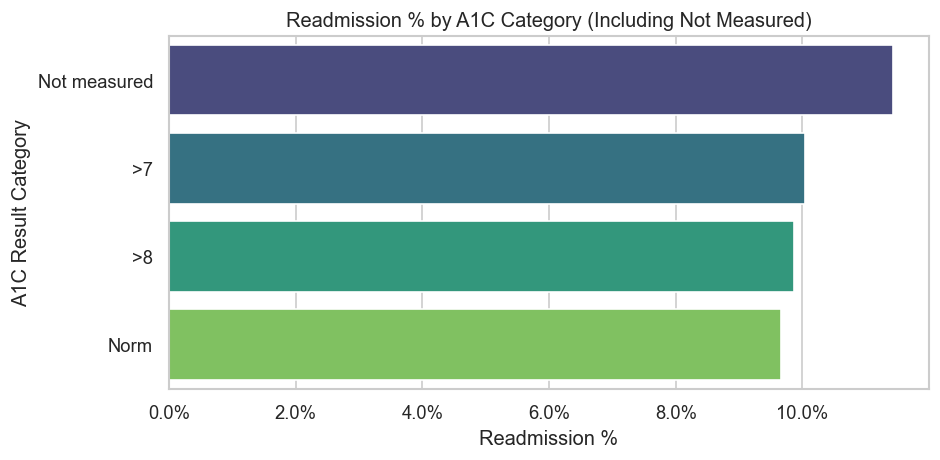

,a1cresult_label,encounters,readmit_count,readmit_pct
3,Not measured,84748,9681,11.423278
0,>7,3812,383,10.047219
1,>8,8216,811,9.870983
2,Norm,4990,482,9.659319


In [15]:
#Visualizing Readmission vs. A1C (Cell E.2)

import matplotlib.ticker as mtick

# Step 3 — Compute readmission % by A1C label
group = (
    df.groupby(a1c_label_col)
      .agg(encounters=('readmit_30d', 'count'),
           readmit_count=('readmit_30d', lambda x: (x == 'Yes').sum()))
      .reset_index()
)
group['readmit_pct'] = 100 * group['readmit_count'] / group['encounters']
group = group.sort_values('readmit_pct', ascending=False)

# Step 4 — Plot the results
plt.figure(figsize=(8, 4))
sns.barplot(data=group, x='readmit_pct', y=a1c_label_col, hue=a1c_label_col, dodge=False, palette='viridis', legend=False)
plt.xlabel('Readmission %')
plt.ylabel('A1C Result Category')
plt.title('Readmission % by A1C Category (Including Not Measured)')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter())
plt.tight_layout()
plt.show()

# Show numeric table as well
group


In [16]:
# A — Create num_distinct_meds (useful feature)
# to summarize medication load per patient (we made _bin med columns earlier):

# create list of med bin columns (we made these in Cell C)
med_bin_cols = [c for c in df.columns if c.endswith('_bin') and c[:-4] in med_cols]

# number of distinct active meds per encounter
df['num_distinct_meds'] = df[med_bin_cols].sum(axis=1).fillna(0).astype(int)

# Quick check
df['num_distinct_meds'].describe()
df['num_distinct_meds'].value_counts().head(10)

num_distinct_meds
1    47314
0    23403
2    21873
3     7778
4     1335
5       58
6        5
Name: count, dtype: int64

In [17]:
# B — Correlation heatmap (numeric features vs readmit flag)
# This will show relationships between readmit (binary) and numeric features (time_in_hospital, num_medications, num_distinct_meds, a1cresult_num_filled, max_glu_serum_num_filled).
# First fill lab numeric NaNs with 0 (if you want numeric correlation):

# Fill lab numbers with 0 for correlation
df['a1cresult_num_filled'] = df['a1cresult_num'].fillna(0)
df['max_glu_serum_num_filled'] = df['max_glu_serum_num'].fillna(0)

# numeric readmit flag
df['readmit_flag'] = np.where(df['readmit_30d']=='Yes', 1, 0)

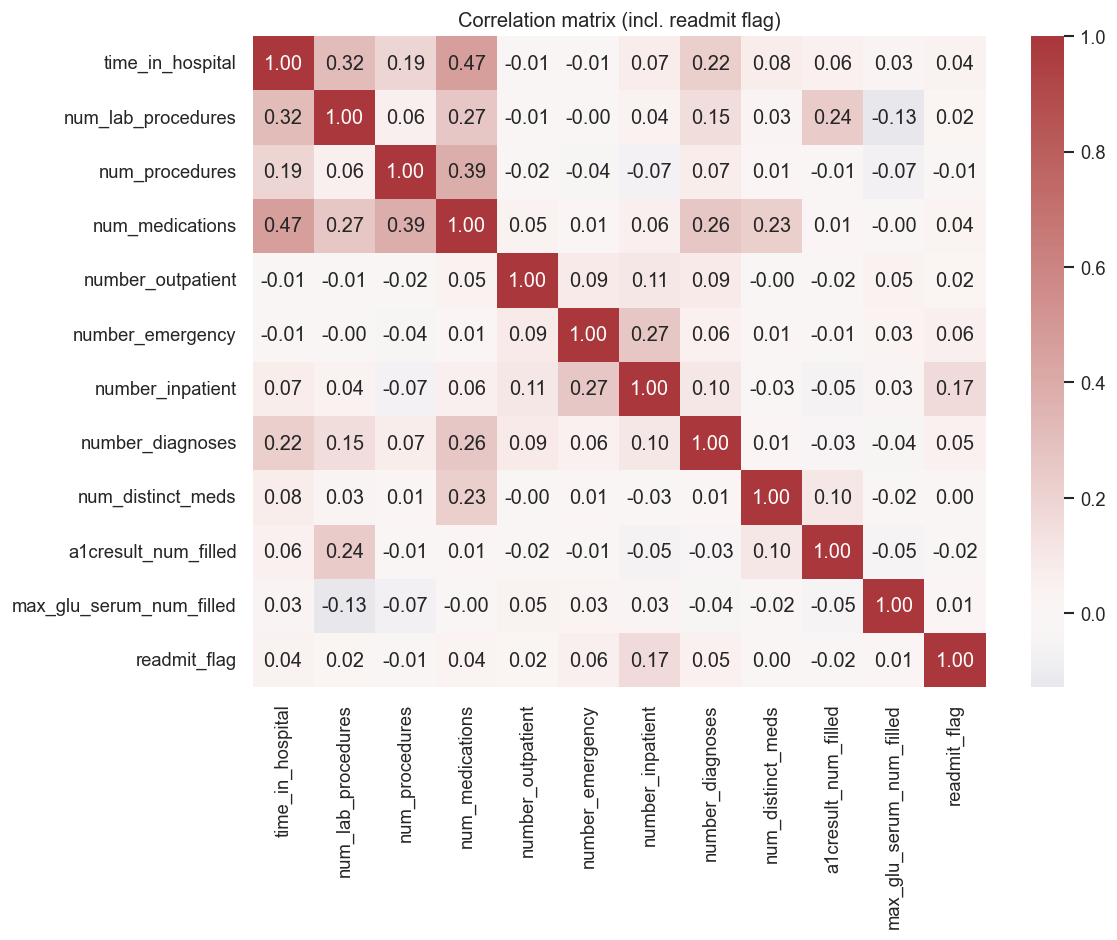

In [18]:
num_features = ['time_in_hospital','num_lab_procedures','num_procedures','num_medications',
                'number_outpatient','number_emergency','number_inpatient','number_diagnoses',
                'num_distinct_meds','a1cresult_num_filled','max_glu_serum_num_filled','readmit_flag']

corr = df[num_features].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='vlag', center=0)
plt.title('Correlation matrix (incl. readmit flag)')
plt.tight_layout()
plt.show()


In [20]:
#final clean data set for tableau

In [20]:
tableau_df = df[[
    'encounter_id', 'patient_nbr', 'gender', 'race', 'age',
    'admission_type_id', 'time_in_hospital', 'num_lab_procedures',
    'num_procedures', 'num_medications', 'number_outpatient',
    'number_emergency', 'number_inpatient', 'number_diagnoses',
    'num_distinct_meds', 'a1cresult_label', 'max_glu_serum_label',
    'readmit_30d', 'readmit_flag'
]].copy()   # <<-- important: forces a true copy

tableau_df.rename(columns={
    'num_lab_procedures': 'Lab_Procedures',
    'num_procedures': 'Procedures',
    'num_medications': 'Medications',
    'number_outpatient': 'Outpatient_Visits',
    'number_emergency': 'Emergency_Visits',
    'number_inpatient': 'Inpatient_Visits',
    'number_diagnoses': 'Diagnoses',
    'num_distinct_meds': 'Distinct_Medications',
    'time_in_hospital': 'Stay_Duration',
    'readmit_30d': 'Readmitted_30Days',
    'a1cresult_label': 'A1C_Result',
    'max_glu_serum_label': 'Glucose_Level'
}, inplace=True)



In [21]:
# Export your tableau_df as CSV
import os

# Define export path
tableau_path = r"C:\Users\007bo\OneDrive\Desktop\IIT\capstone\2\tableau_export\healthcare_tableau_ready.csv"

# Create directory if missing
os.makedirs(os.path.dirname(tableau_path), exist_ok=True)

# Export as CSV
tableau_df.to_csv(tableau_path, index=False)

print(f"✅ Tableau file exported successfully at:\n{tableau_path}")
print(f"Shape: {tableau_df.shape}")


✅ Tableau file exported successfully at:
C:\Users\007bo\OneDrive\Desktop\IIT\capstone\2\tableau_export\healthcare_tableau_ready.csv
Shape: (101766, 19)
